# Baseline

## Set-up
- Download the [Depresjon dataset](https://datasets.simula.no/depresjon/), unpack it, and place it in the current directory.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

In [2]:
seed = 0

## Data

We generate a simple dataset with the mean and standard deviation of a given person's activity as our two features.

In [3]:
data_dir = 'data'

n = len(os.listdir(os.path.join(data_dir, 'condition'))) + len(os.listdir(os.path.join(data_dir, 'control')))
data = np.empty((n, 3))
i = 0

for k, v in {'condition': 1, 'control': 0}.items():
    for file in os.listdir(os.path.join(data_dir, k)):
        activity = np.genfromtxt(os.path.join(data_dir, k, file), delimiter=',', skip_header=True, usecols=[2])
        data[i, :] = np.array([np.mean(activity), np.std(activity), v])
        i += 1

X = data[:, :2]
y = data[:, 2]

## Model

We use a logistic regression model using 11-fold cross validation as our baseline.

In [4]:
folds = int(n / 5)
clf = LogisticRegressionCV(cv=folds, random_state=seed).fit(X, y)
y_pred = clf.predict(X)
acc = clf.score(X, y)
f1 = f1_score(y, y_pred)
print('Acc: ', acc)
print('F1: ', f1)

Acc:  0.6363636363636364
F1:  0.47368421052631576


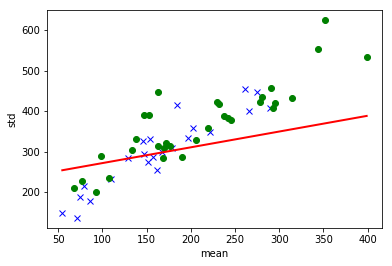

In [5]:
# Code for plotting taken from CS 229 assignments.
plt.figure()
plt.plot(X[y == 1, -2], X[y == 1, -1], 'bx', linewidth=2, label='condition')
plt.plot(X[y == 0, -2], X[y == 0, -1], 'go', linewidth=2, label='control')

# Plot decision boundary (found by solving for theta^T x = 0).
x1 = np.arange(min(X[:, -2]), max(X[:, -2]), 0.01)
x2 = -(clf.intercept_[0] / clf.coef_[0][1] + clf.coef_[0][0] / clf.coef_[0][1] * x1)
plt.plot(x1, x2, c='red', linewidth=2)

# Add labels and display.
plt.xlabel('mean')
plt.ylabel('std')
plt.show()